# <span style="color:blue"> Forecast the GDP per capita of Ivory Coast in 2021</span>

<div class="alert alert-block alert-info">In this mini project, the objective is to forecast the GDP per capita in Ivory Coast for the year 2021, utilizing the data collected from the World Bank, which is available up to 2021. The first model employed is a SARIMA model, while the second model incorporates additional 'independent' or 'exogenous' variables, using a SARIMAX model. Subsequently, we will evaluate and compare the performance of both models to determine which one produces the most accurate predictions.</div>

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# load the data in the jupyter notebook terminal

df = pd.read_excel(r'C:\Users\HP\pyfold\Python Learning Materials\Civ data.xlsx')
df.head()

,Years,"Population, total",GDP per capita (current US$),"Inflation, GDP deflator (annual %)"
0,1960,3708661,147.277835,NaN
1,1961,3848336,160.652718,2.990063
2,1962,3998287,161.390202,3.004820
3,1963,4156453,183.100121,3.013917
4,1964,4321368,213.141595,2.906178


In [3]:
df.shape

(62, 4)

In [4]:
# let's change the column names for convenience

df.rename(columns ={'Population, total': 'Population'}, inplace=True)
df.rename(columns ={'GDP per capita (current US$)': 'GDP'}, inplace=True)
df.rename(columns ={'Inflation, GDP deflator (annual %)': 'Inflation(%)'}, inplace=True)

df.head()

,Years,Population,GDP,Inflation(%)
0,1960,3708661,147.277835,NaN
1,1961,3848336,160.652718,2.990063
2,1962,3998287,161.390202,3.004820
3,1963,4156453,183.100121,3.013917
4,1964,4321368,213.141595,2.906178


In [5]:
#let's replace the first value of the inflation (which is actually a missing number) by the next value

df['Inflation(%)'].replace(df['Inflation(%)'].iloc[0], value=None, method='bfill', inplace=True )

df.head()

,Years,Population,GDP,Inflation(%)
0,1960,3708661,147.277835,2.990063
1,1961,3848336,160.652718,2.990063
2,1962,3998287,161.390202,3.004820
3,1963,4156453,183.100121,3.013917
4,1964,4321368,213.141595,2.906178


In [6]:
# let's check the data types of each variables

df.dtypes

Years             int64
Population        int64
GDP             float64
Inflation(%)    float64
dtype: object

In [7]:
# let's define the target and the predictors or exogenous variables

target = df['GDP']
exog  = df[['Population', 'Inflation(%)']]

## SARIMA MODEL

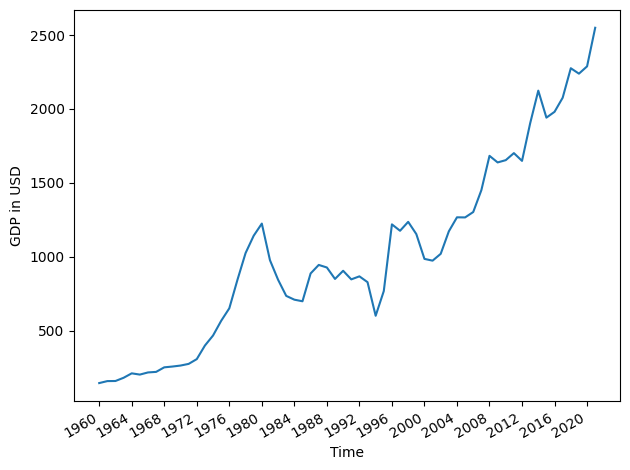

In [8]:
# let's plot the series (target variable) for a first observation

fig, ax = plt.subplots()

ax.plot(df['GDP'])

ax.set_xlabel('Time')
ax.set_ylabel('GDP in USD')

plt.xticks(np.arange(0, 61, 4), np.arange(1960, 2021, 4))

fig.autofmt_xdate()
plt.tight_layout()

There is no apparent seasonality in the series

In [9]:
# let's check the stationarity of the target with the Augmented Dickey Fuller test (ADF)

ad_fuller_result = adfuller(df['GDP'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 0.6181233044293819
p-value: 0.9880539223487291


In [10]:
# let's perform a one-order differencing as the series is clearly not stationary

diff_df = np.diff(df['GDP'])

ad_fuller_result = adfuller(diff_df)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.84429960877064
p-value: 3.7145877459926503e-07


we can now reject the null hypothesis stating that there is a unit root in the series. The series is now stationary

In [11]:
# let's split the data into train and test set

train = df[:61]
test = df[61:]

print(len(train), len(test))

61 1


In [12]:
from pmdarima import auto_arima

y = df['GDP']

# Define the order of seasonal differencing, denoted by (p, d, q, P, D, Q, m)
# p: order of the AR (autoregressive) component
# d: order of differencing
# q: order of the MA (moving average) component
# P: order of the seasonal AR component
# D: order of seasonal differencing
# Q: order of the seasonal MA component
# m: number of time steps in each seasonal period (e.g., m=12 for monthly data with yearly seasonality)


# Use auto_arima to determine the best hyperparameters
model = auto_arima(y, seasonal=True, m=1, 
                   start_p=0, start_q=0, max_p=5, max_q=5, 
                   start_P=0, start_Q=0, max_P=5, max_Q=5, 
                   stepwise=True, trace=True, 
                   information_criterion='aic')

# Print the summary of the best model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=761.641, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=761.628, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=760.181, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=765.834, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=760.442, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=759.628, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=760.912, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=761.375, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=762.775, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=763.191, Time=0.06 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.165 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   62
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -3

since there is no apparent seasonality, we are fitting an __ARIMA(0, 1, 2) model__ as suggested by the pmdarima library!

In [13]:
# let's fit the model

best_model = SARIMAX(train['GDP'], order=(0, 1, 2), simple_differencing=False)

model = best_model.fit(disp=False)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   61
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -371.210
Date:                Thu, 01 Jun 2023   AIC                            748.421
Time:                        09:41:37   BIC                            754.704
Sample:                             0   HQIC                           750.879
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3026      0.110      2.742      0.006       0.086       0.519
ma.L2         -0.0941      0.126     -0.749      0.454      -0.340       0.152
sigma2      1.382e+04   2546.094      5.426      0.0

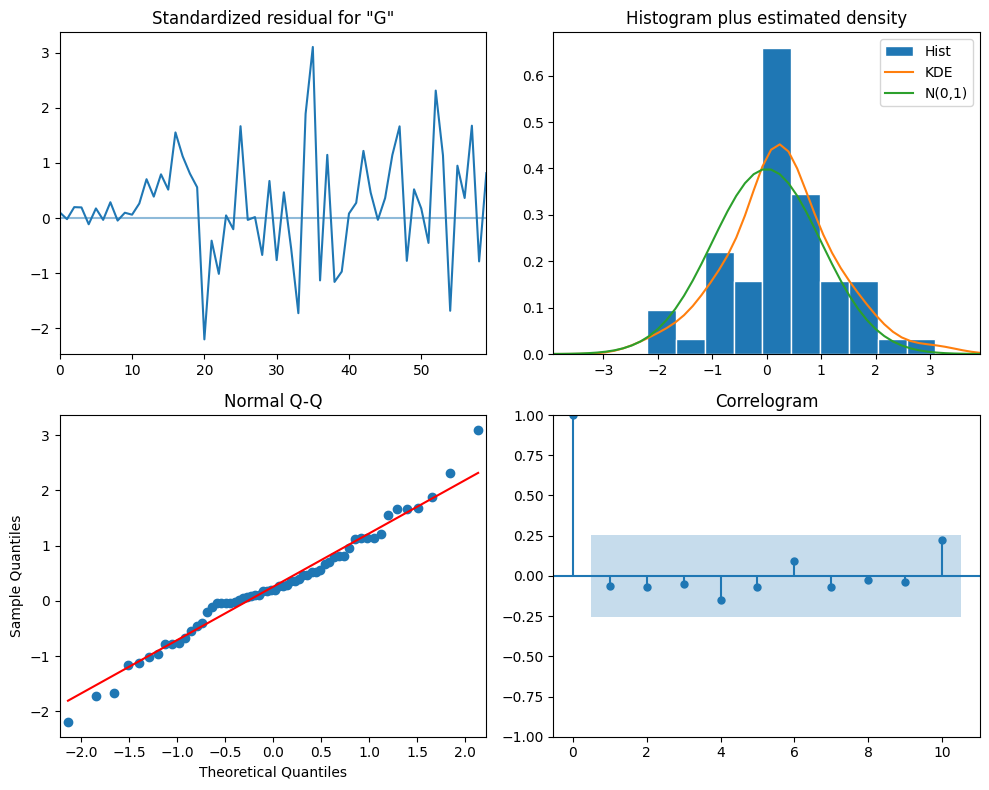

In [14]:
# let's analyze the residuals

model.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

the residuals look like white noise

In [15]:
# let's perform the Ljung Box Statistic test

Residuals =  model.resid

acorr_ljungbox(Residuals, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.262661,0.608298
2,0.580714,0.747997
3,0.756223,0.859907
4,2.233512,0.692899
5,2.629974,0.756806
6,3.217697,0.781069
7,3.617190,0.822661
8,3.659985,0.886425
9,3.803806,0.923844
10,7.251938,0.701466


the p-values are everywhere greater than 0.05, meaning we cannot reject the null hypothesis that states that the residuals are independently distrinuted. Therefore, they are uncorrelated!

let's define a function to perform a grid search so as to find the best parameters p and q and compare with them with the pmdarima library 

In [16]:
#let's select the appropriate model based upon the AIC 

def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
# let's create a list of possible values for the parameters p, q, P and Q

ps = range(0, 4, 1)
qs = range(0, 4, 1)

d = 1

order_list = list(product(ps, qs))

sarima_result_df = optimize_SARIMA(train['GDP'], order_list, d)

sarima_result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(0, 1)",746.954669
1,"(1, 0)",748.133629
2,"(1, 1)",748.406019
3,"(0, 2)",748.420887
4,"(2, 0)",748.966270
5,"(0, 0)",749.981571
6,"(2, 2)",749.987989
7,"(1, 3)",750.080960
8,"(2, 1)",750.398917
9,"(1, 2)",750.399655


In [18]:
# let's fit the model and name it model2

best_model2 = SARIMAX(train['GDP'], order=(0,1,1), simple_differencing=False)

model2 = best_model2.fit(disp=False)

print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                    GDP   No. Observations:                   61
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -371.477
Date:                Thu, 01 Jun 2023   AIC                            746.955
Time:                        09:41:45   BIC                            751.143
Sample:                             0   HQIC                           748.593
                                 - 61                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3267      0.099      3.312      0.001       0.133       0.520
sigma2      1.394e+04   2279.010      6.118      0.000    9475.524    1.84e+04
Ljung-Box (L1) (Q):                   0.41   Jarque-

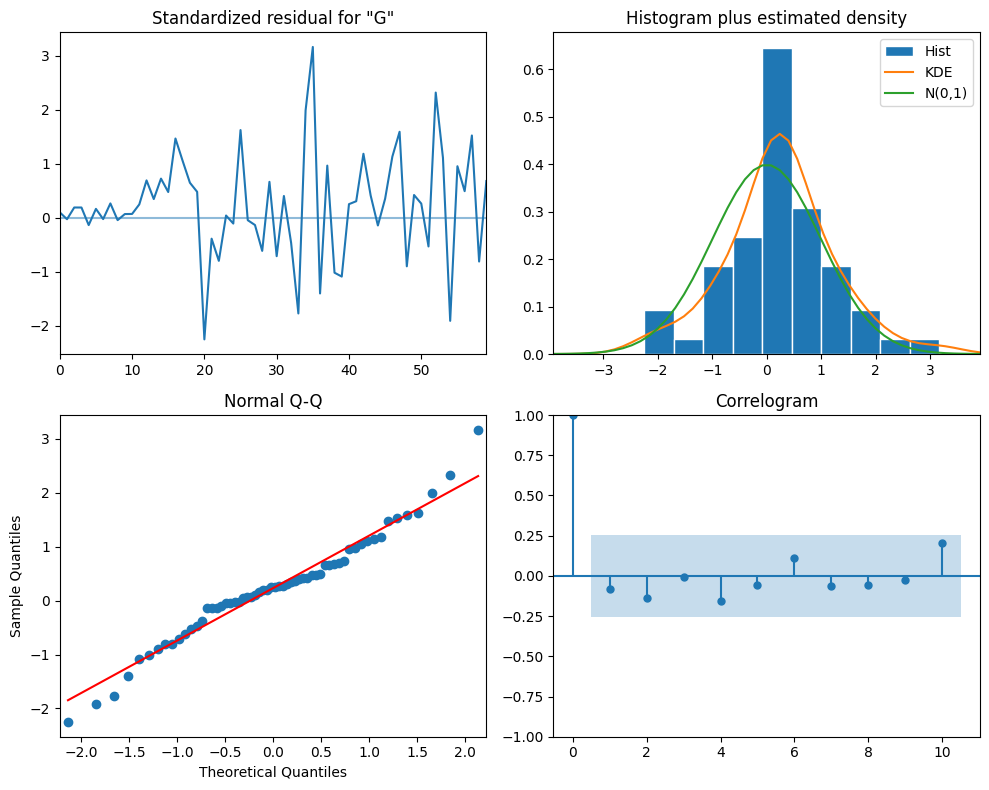

In [19]:
# let's analyse the residuals of model 2

model2.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

They resemble wite noise

In [20]:
# let's perform the Ljung Box Statistic test on model 2

Residuals2 =  model2.resid

acorr_ljungbox(Residuals2, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.422011,0.515935
2,1.657500,0.436595
3,1.662115,0.645389
4,3.301086,0.508760
5,3.578960,0.611475
6,4.409865,0.621391
7,4.744051,0.691165
8,4.937356,0.764250
9,5.004450,0.833920
10,7.968561,0.631908


we cannot reject the null hypothesis, the residuals are uncorrelated!

In [21]:
# let's forecast the test set with both models

pred_SARIMA =  model.get_prediction(60, 61).predicted_mean
pred_SARIMA2 =  model2.get_prediction(60, 61).predicted_mean

test.loc[:,'pred_SARIMA'] = pred_SARIMA
test.loc[:,'pred_SARIMA2'] = pred_SARIMA2

test

,Years,Population,GDP,Inflation(%),pred_SARIMA,pred_SARIMA2
61,2021,27478249,2549.041297,2.763518,2325.765268,2314.426638


## SARIMAX MODEL

In [23]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [24]:
p = range(0, 4, 1)
q = range(0, 4, 1)
d = 1


parameters = product(p, q)
parameters_list = list(parameters)

target_train = target[:61]
exog_train = exog[:61]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(0, 2)",744.651148
1,"(2, 0)",744.667622
2,"(0, 1)",744.910660
3,"(1, 2)",745.000933
4,"(1, 1)",745.996914
5,"(1, 0)",746.453494
6,"(2, 1)",746.616924
7,"(3, 0)",746.657176
8,"(2, 2)",746.867713
9,"(0, 3)",746.906894


In [39]:
# let's fit a SARIMAX model

best_modelx = SARIMAX(target_train, exog_train, order=(0, 1, 1), simple_differencing=True)

model_x = best_modelx.fit(disp=False)

print(model_x.summary())


                               SARIMAX Results                                
Dep. Variable:                  D.GDP   No. Observations:                   60
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -368.456
Date:                Thu, 01 Jun 2023   AIC                            744.911
Time:                        09:56:59   BIC                            753.289
Sample:                             0   HQIC                           748.188
                                 - 60                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Population    8.846e-05   4.29e-05      2.063      0.039    4.43e-06       0.000
Inflation(%)     1.2252      0.608      2.016      0.044       0.034       2.416
ma.L1            0.2693      0.112      2.40

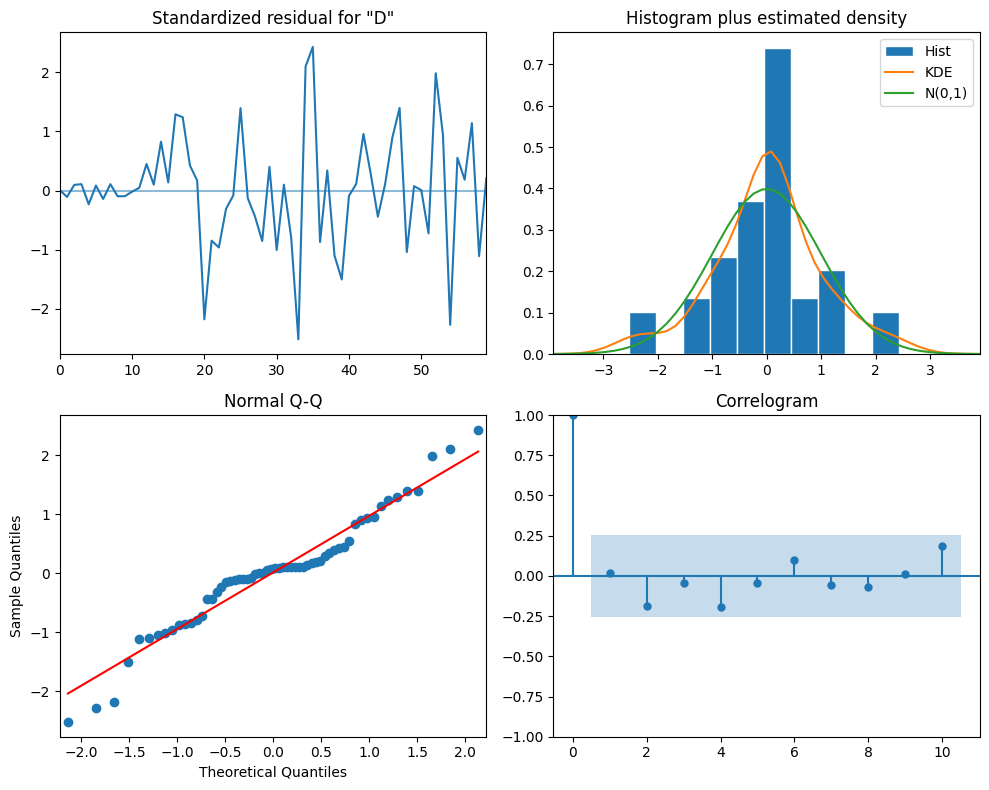

In [26]:
# let's analyse the residuals

model_x.plot_diagnostics(figsize=(10,8))
plt.tight_layout()

the residuals look like white noise

In [27]:
# let's perform the Ljung Box Statistic test on model 2

Residuals3 =  model_x.resid

acorr_ljungbox(Residuals3, lags=np.arange(1,11,1), return_df=True)

,lb_stat,lb_pvalue
1,0.022407,0.881009
2,2.255397,0.323778
3,2.380291,0.497314
4,4.836415,0.304498
5,4.968543,0.419731
6,5.675912,0.460455
7,5.901010,0.551354
8,6.254798,0.618714
9,6.262896,0.713345
10,8.877303,0.543786


the residuals are uncorrelated

let's define a function to frecast the test set 

In [34]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'SARIMAX':
        pred_SARIMAX = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(0,1,1), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)
            
        return pred_SARIMAX

In [35]:
target_train = target[:61]
target_test = target[61:]


TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

test['pred_last_value'] = pred_last_value
test['pred_SARIMAX'] = pred_SARIMAX

test

,Years,Population,GDP,Inflation(%),pred_SARIMA,pred_SARIMA2,pred_last_value,pred_SARIMAX
61,2021,27478249,2549.041297,2.763518,2325.765268,2314.426638,2288.119498,2263.510467


In [36]:
# let's define a function to calculate the MAPE (Mean Absolute Percentage Error)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [37]:
# let's calculate the MAPE (Mean Absolute Percentage Error) for all predictions

mape_last = mape(test.GDP, test.pred_last_value)
mape_SARIMAX = mape(test.GDP, test.pred_SARIMAX)
mape_SARIMA = mape(test.GDP, test.pred_SARIMA)
mape_SARIMA2 = mape(test.GDP, test.pred_SARIMA2)

print(mape_last, mape_SARIMAX, mape_SARIMA, mape_SARIMA2)

10.236075810492922 11.201498790378922 8.75921585324658 9.204035225541741


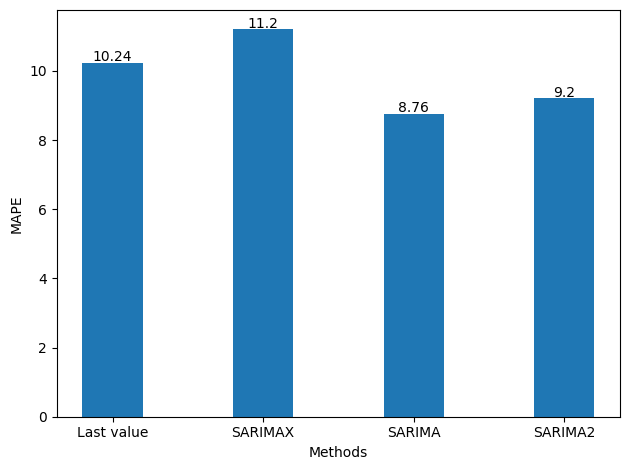

In [45]:
fig, ax = plt.subplots()

x = ['Last value', 'SARIMAX', 'SARIMA', 'SARIMA2']
y = [mape_last, mape_SARIMAX, mape_SARIMA, mape_SARIMA2]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Methods')
ax.set_ylabel('MAPE')

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()